## Observations and Insights 

In [36]:
%matplotlib notebook

# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

In [37]:
# Combine the data into a single dataset
mouse_study_df = pd.merge(mouse_metadata, study_results, on="Mouse ID")

In [38]:
# Display the data table for preview
mouse_study_df.head()

Mouse ID Drug Regimen   Sex  Age_months  Weight (g)  Timepoint  \
0     k403     Ramicane  Male          21          16          0   
1     k403     Ramicane  Male          21          16          5   
2     k403     Ramicane  Male          21          16         10   
3     k403     Ramicane  Male          21          16         15   
4     k403     Ramicane  Male          21          16         20   

   Tumor Volume (mm3)  Metastatic Sites  
0           45.000000                 0  
1           38.825898                 0  
2           35.014271                 1  
3           34.223992                 1  
4           32.997729                 1

In [39]:
# Calculate number of rows prior to row-level deduplication
mouse_ttl_rows = len(mouse_study_df.index)
mouse_ttl_rows

1893

In [40]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
# Use drop_duplicates with parameter subset, for keeping only last duplicated rows add
mouse_study_dedupe_df = mouse_study_df.drop_duplicates(subset=["Mouse ID","Timepoint"])
mouse_study_dedupe_df.head()

Mouse ID Drug Regimen   Sex  Age_months  Weight (g)  Timepoint  \
0     k403     Ramicane  Male          21          16          0   
1     k403     Ramicane  Male          21          16          5   
2     k403     Ramicane  Male          21          16         10   
3     k403     Ramicane  Male          21          16         15   
4     k403     Ramicane  Male          21          16         20   

   Tumor Volume (mm3)  Metastatic Sites  
0           45.000000                 0  
1           38.825898                 0  
2           35.014271                 1  
3           34.223992                 1  
4           32.997729                 1

In [41]:
# Calculate number of rows after row-level deduplication
mouse_dedupe_ttl_rows = len(mouse_study_dedupe_df.index)
print(f"After deduplication, there are {mouse_dedupe_ttl_rows} rows in the dataset.")
print(f"The deduplication removed {mouse_ttl_rows - mouse_dedupe_ttl_rows} rows from the original data set.")

After deduplication, there are 1888 rows in the dataset.
The deduplication removed 5 rows from the original data set.


In [42]:
# Optional: Get all the data for the duplicate mouse ID. 
# The first line of code declares the following logic:
#     If the a row has values for columns Mouse ID and Timepoint that are identical to those of another row, 
#     assign row value = True.
# The second line of code instructs the dataframe to serve up unique instances of duplicate rows, with a default
#     of selecting all but the first row of each grouping of duplicate rows.

has_duplicates = mouse_study_df.duplicated(subset=["Mouse ID","Timepoint"])
duplicates = mouse_study_df[has_duplicates]
duplicates

Mouse ID Drug Regimen     Sex  Age_months  Weight (g)  Timepoint  \
909     g989     Propriva  Female          21          26          0   
911     g989     Propriva  Female          21          26          5   
913     g989     Propriva  Female          21          26         10   
915     g989     Propriva  Female          21          26         15   
917     g989     Propriva  Female          21          26         20   

     Tumor Volume (mm3)  Metastatic Sites  
909           45.000000                 0  
911           47.570392                 0  
913           49.880528                 0  
915           53.442020                 0  
917           54.657650                 1

In [43]:
# Checking the number of mice in the clean DataFrame.
mouse_study_dedupe_df["Mouse ID"].nunique()

249

In [44]:
# Identify Drug Regigmens
drugs_list = mouse_study_dedupe_df["Drug Regimen"].unique()
drugs_num = mouse_study_dedupe_df["Drug Regimen"].nunique()
print(f"There are {drugs_num} Drug Regimens as part of this study, including:")
print(*drugs_list, sep = ", ")


There are 10 Drug Regimens as part of this study, including:
Ramicane, Capomulin, Infubinol, Placebo, Ceftamin, Stelasyn, Zoniferol, Ketapril, Propriva, Naftisol


In [45]:
# Examine data types for the cleaned DataFrame
mouse_study_dedupe_df.dtypes

Mouse ID               object
Drug Regimen           object
Sex                    object
Age_months              int64
Weight (g)              int64
Timepoint               int64
Tumor Volume (mm3)    float64
Metastatic Sites        int64
dtype: object

## Summary Statistics

In [46]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume.


In [47]:
# *****IMPORTANT*****
# Apparently, I may have answered this question differently than was instructed.  BUT my response is that what was 
#     instructed, an average of tumor size by drug could have led to badly skewed analysis.  Instead, the only way
#     to meaningfully analyze the data is first to take an average of tumor size measurements for each mouse, and
#     then to roll those averages into a set from which a second average value is calculated.  

#     Here's why in simple terms.  Say for a specific drug study there were 10 tumor size measurements for one mouse 
#     and 2 measurements for another mouse.  The instructed approach says to take an average for all tumor measurements.
#     This means that the instructed approach would allow the first mouse's tumor measurements to have 10x the 
#     weighting of the second mouse's tumor measurements.  This just doesn't make logical sense.  The question is trying 
#     to get at the average tumor size for each mouse.  My methodology - taking an average of averages - weights each
#     mouse equally in calculating an average tumor for the mouse population within each specific drug study.

#     I replicated this Groupby methodology for subseqent calculations: median, variance, standard deviation, and SEM.

In [48]:
# Calculate Average for Tumor Volume by Drug Regimen 
# Using a 2-variable Groupby operation with Drug Regimen as primary cluster and Mouse ID as secondary cluster,
#    and a second 2-variable Groupby operation by Drug Regimen as primary cluster and Tumor Volume as secondary field,
#    we were able to calculate average tumor size per mouse, and then roll up an average for each group of mice
#    subjected to a specific drug regimen.
# Method: groups using average of averages

avg_tumor_volume_by_drug = mouse_study_dedupe_df \
     .groupby(["Drug Regimen", "Mouse ID"], as_index=False) \
     .mean() \
     .groupby("Drug Regimen")["Tumor Volume (mm3)"] \
     .mean()
avg_tumor_volume_by_drug

Drug Regimen
Capomulin    40.755487
Ceftamin     50.827485
Infubinol    51.383443
Ketapril     53.432527
Naftisol     52.499395
Placebo      52.540611
Propriva     50.613641
Ramicane     40.555988
Stelasyn     52.662319
Zoniferol    51.562955
Name: Tumor Volume (mm3), dtype: float64

In [49]:
# Show the base groupby object - with Drug Regimen master cluster and Mouse ID slave cluster
tumor_volume_by_drug_avg_for_mouse = mouse_study_dedupe_df \
     .groupby(["Drug Regimen", "Mouse ID"]) \
     .mean()
tumor_volume_by_drug_avg_for_mouse

Age_months  Weight (g)  Timepoint  Tumor Volume (mm3)  \
Drug Regimen Mouse ID                                                          
Capomulin    b128             9.0        22.0       22.5           41.963636   
             b742             7.0        21.0       22.5           40.083699   
             f966            16.0        17.0       10.0           36.505973   
             g288             3.0        19.0       22.5           41.990097   
             g316            22.0        22.0       22.5           44.613344   
...                           ...         ...        ...                 ...   
Zoniferol    q633            12.0        25.0       22.5           56.124896   
             s337            14.0        27.0       22.5           51.515155   
             w140            19.0        30.0        2.5           46.358976   
             w575            16.0        28.0       22.5           56.627561   
             x613             2.0        29.0        7.5           46.498216   

                       Metastatic Sites  
Drug Regimen Mouse ID                    
Capomulin    b128                   0.7  
             b742                   0.0  
             f966                   0.0  
             g288                   0.8  
             g316                   1.0  
...                                 ...  
Zoniferol    q633                   0.9  
             s337                   1.7  
             w140                   0.0  
             w575                   1.4  
             x613                   0.0  

[249 rows x 5 columns]

In [50]:
# Calculate Median for Tumor Volume by Drug Regimen
# Method: groups using median of averages
median_tumor_volume_by_drug = mouse_study_dedupe_df \
     .groupby(["Drug Regimen", "Mouse ID"], as_index=False) \
     .mean() \
     .groupby("Drug Regimen")["Tumor Volume (mm3)"] \
     .median()
median_tumor_volume_by_drug

Drug Regimen
Capomulin    41.384825
Ceftamin     52.128041
Infubinol    51.897959
Ketapril     53.725479
Naftisol     53.353053
Placebo      53.392180
Propriva     49.923649
Ramicane     40.108578
Stelasyn     52.651204
Zoniferol    52.437635
Name: Tumor Volume (mm3), dtype: float64

In [51]:
# Calculate Variance for Tumor Volume by Drug Regimen
# Method: groups using variance of averages
var_tumor_volume_by_drug = mouse_study_dedupe_df \
     .groupby(["Drug Regimen", "Mouse ID"], as_index=False) \
     .mean() \
     .groupby("Drug Regimen")["Tumor Volume (mm3)"] \
     .var()
var_tumor_volume_by_drug

Drug Regimen
Capomulin    10.529290
Ceftamin     14.040506
Infubinol    17.380408
Ketapril     24.086484
Naftisol     22.886774
Placebo      19.610351
Propriva     15.402512
Ramicane     10.256711
Stelasyn     22.147071
Zoniferol    16.782584
Name: Tumor Volume (mm3), dtype: float64

In [52]:
# Calculate Standard Deviation for Tumor Volume by Drug Regimen
# Method: groups using standard deviation of averages
std_tumor_volume_by_drug = mouse_study_dedupe_df \
     .groupby(["Drug Regimen", "Mouse ID"], as_index=False) \
     .mean() \
     .groupby("Drug Regimen")["Tumor Volume (mm3)"] \
     .std()
std_tumor_volume_by_drug

Drug Regimen
Capomulin    3.244887
Ceftamin     3.747066
Infubinol    4.168982
Ketapril     4.907798
Naftisol     4.784012
Placebo      4.428358
Propriva     3.924603
Ramicane     3.202610
Stelasyn     4.706067
Zoniferol    4.096655
Name: Tumor Volume (mm3), dtype: float64

In [53]:
# Calculate Standard Error from the Mean (SEM) for Tumor Volume by Drug Regimen
# Method: groups using SEM of averages
sem_tumor_volume_by_drug = mouse_study_dedupe_df \
     .groupby(["Drug Regimen", "Mouse ID"], as_index=False) \
     .mean() \
     .groupby("Drug Regimen")["Tumor Volume (mm3)"] \
     .sem()
sem_tumor_volume_by_drug

Drug Regimen
Capomulin    0.648977
Ceftamin     0.749413
Infubinol    0.833796
Ketapril     0.981560
Naftisol     0.956802
Placebo      0.885672
Propriva     0.784921
Ramicane     0.640522
Stelasyn     0.960622
Zoniferol    0.819331
Name: Tumor Volume (mm3), dtype: float64

In [54]:
# Calculate the number of mice (unique) involved in each Drug Regimen study
mice_count_by_drug = mouse_study_dedupe_df \
     .groupby(["Drug Regimen", "Mouse ID"], as_index=False) \
     .mean() \
     .groupby("Drug Regimen")["Tumor Volume (mm3)"] \
     .count()
mice_count_by_drug

Drug Regimen
Capomulin    25
Ceftamin     25
Infubinol    25
Ketapril     25
Naftisol     25
Placebo      25
Propriva     25
Ramicane     25
Stelasyn     24
Zoniferol    25
Name: Tumor Volume (mm3), dtype: int64

In [55]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
# I added mice count to the summary table.
# Assemble the resulting series into a single summary dataframe.
# Create data frame with obtained values
tumor_vol_summary_df = pd.DataFrame({"Tumor Vol Avg": avg_tumor_volume_by_drug, 
                                     "Tumor Vol Median": median_tumor_volume_by_drug,
                                     "Tumor Vol Var": var_tumor_volume_by_drug,
                                     "Tumor Vol StD": std_tumor_volume_by_drug,
                                     "Tumor Vol SEM": sem_tumor_volume_by_drug,
                                     "Mice Count": mice_count_by_drug})

print(f"Analysis of Tumor Volume (mm3) by Drug Regimen\n")
print(f"Variance measures the spread between numbers in a data set.")
print(f"Standard Deviation (StD) provides a 'standard' way of knowing what is normal and what is not in a numbers spread.")
print(f"Standard Error from the Mean (SEM) is similar to StD, but tells how far a sample  mean might deviate from a population mean.")

tumor_vol_summary_df

Analysis of Tumor Volume (mm3) by Drug Regimen

Variance measures the spread between numbers in a data set.
Standard Deviation (StD) provides a 'standard' way of knowing what is normal and what is not in a numbers spread.
Standard Error from the Mean (SEM) is similar to StD, but tells how far a sample  mean might deviate from a population mean.


Tumor Vol Avg  Tumor Vol Median  Tumor Vol Var  Tumor Vol StD  \
Drug Regimen                                                                  
Capomulin         40.755487         41.384825      10.529290       3.244887   
Ceftamin          50.827485         52.128041      14.040506       3.747066   
Infubinol         51.383443         51.897959      17.380408       4.168982   
Ketapril          53.432527         53.725479      24.086484       4.907798   
Naftisol          52.499395         53.353053      22.886774       4.784012   
Placebo           52.540611         53.392180      19.610351       4.428358   
Propriva          50.613641         49.923649      15.402512       3.924603   
Ramicane          40.555988         40.108578      10.256711       3.202610   
Stelasyn          52.662319         52.651204      22.147071       4.706067   
Zoniferol         51.562955         52.437635      16.782584       4.096655   

              Tumor Vol SEM  Mice Count  
Drug Regimen                             
Capomulin          0.648977          25  
Ceftamin           0.749413          25  
Infubinol          0.833796          25  
Ketapril           0.981560          25  
Naftisol           0.956802          25  
Placebo            0.885672          25  
Propriva           0.784921          25  
Ramicane           0.640522          25  
Stelasyn           0.960622          24  
Zoniferol          0.819331          25

In [56]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume 
#      for each regimen

# Using the aggregation method, produce the same summary statistics in a single line
tumor_vol_summary_df2 = mouse_study_dedupe_df \
     .groupby(["Drug Regimen", "Mouse ID"], as_index=False) \
     .mean() \
     .groupby("Drug Regimen")["Tumor Volume (mm3)"] \
     .aggregate(["mean", "median", "var", "std", "sem", "count"])

tumor_vol_summary_df2

mean     median        var       std       sem  count
Drug Regimen                                                            
Capomulin     40.755487  41.384825  10.529290  3.244887  0.648977     25
Ceftamin      50.827485  52.128041  14.040506  3.747066  0.749413     25
Infubinol     51.383443  51.897959  17.380408  4.168982  0.833796     25
Ketapril      53.432527  53.725479  24.086484  4.907798  0.981560     25
Naftisol      52.499395  53.353053  22.886774  4.784012  0.956802     25
Placebo       52.540611  53.392180  19.610351  4.428358  0.885672     25
Propriva      50.613641  49.923649  15.402512  3.924603  0.784921     25
Ramicane      40.555988  40.108578  10.256711  3.202610  0.640522     25
Stelasyn      52.662319  52.651204  22.147071  4.706067  0.960622     24
Zoniferol     51.562955  52.437635  16.782584  4.096655  0.819331     25

In [57]:
tumor_vol_summary_df2.dtypes

mean      float64
median    float64
var       float64
std       float64
sem       float64
count       int64
dtype: object

## Bar and Pie Charts

In [58]:
# Matplotlib's pyplot is the library that Pandas uses in its plot function. 
# Pandas' DataFrame.plot() is only a convenient shortcut. 

# "Matplotlib is a Python package that is widely used throughout the scientific Python community 
# to create high-quality and publication-ready graphics. It supports a wide range of raster and 
# vector graphics formats including PNG, PostScript, EPS, PDF and SVG.  Moreover, matplotlib is the 
# actual engine behind the plotting capabilities of both Pandas and plotnine packages. For example, 
# when we call the .plot method on Pandas data objects, we actually use the matplotlib package."

# https://datacarpentry.org/python-ecology-lesson/08-putting-it-all-together/index.html

<IPython.core.display.Javascript object>


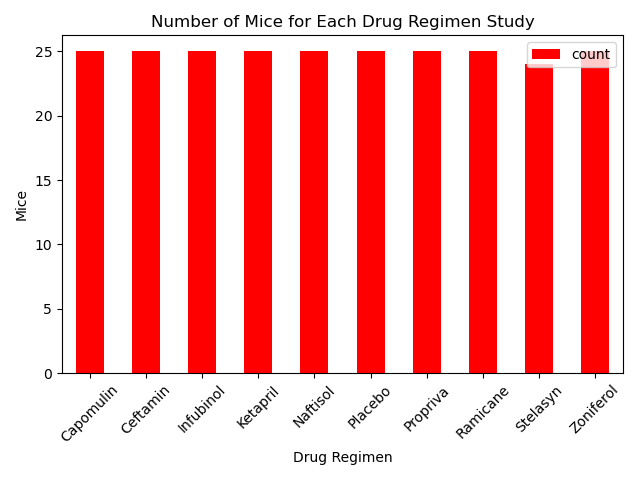

In [26]:
# Generate a bar plot showing the total number of unique mice tested on each drug regimen using pandas.
ax = tumor_vol_summary_df2.plot.bar(y=["count"], color="r", align="center", title="Number of Mice for Each Drug Regimen Study")
ax.set_ylabel("Mice")
plt.xticks(rotation=45)
# ax.set_ylabel("Mice")

plt.tight_layout()

In [ ]:
# Generate a bar plot showing the total number of unique mice tested on each drug regimen using pyplot.



<IPython.core.display.Javascript object>


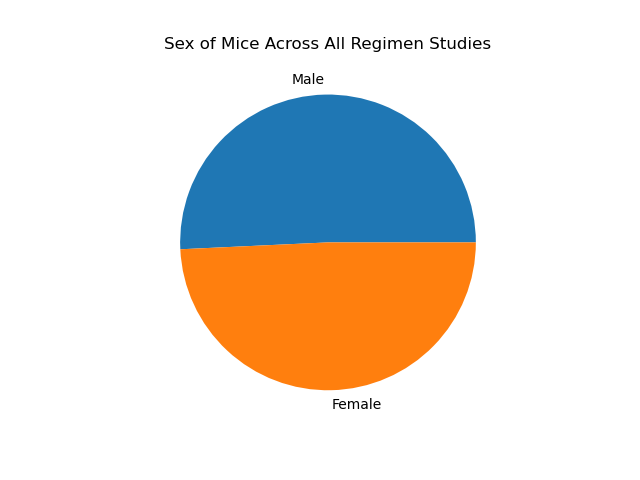

<ipython-input-27-ae58d75120c2>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = plt.axes()


In [27]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
mice_sex_all_studies_df = pd.DataFrame(mouse_study_dedupe_df["Sex"].value_counts())
ax2 = mice_sex_all_studies_df.plot.pie(y="Sex", title="Sex of Mice Across All Regimen Studies")
ax2 = plt.axes()
ax2.yaxis.label.set_visible(False)
ax2.get_legend().remove()

In [ ]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot



## Quartiles, Outliers and Boxplots

In [73]:
promising_drugs = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]
mouse_study_promising_drugs_df = mouse_study_dedupe_df.loc[mouse_study_dedupe_df["Drug Regimen"].isin(promising_drugs)]
mouse_study_promising_drugs_df.head()

Mouse ID Drug Regimen   Sex  Age_months  Weight (g)  Timepoint  \
0     k403     Ramicane  Male          21          16          0   
1     k403     Ramicane  Male          21          16          5   
2     k403     Ramicane  Male          21          16         10   
3     k403     Ramicane  Male          21          16         15   
4     k403     Ramicane  Male          21          16         20   

   Tumor Volume (mm3)  Metastatic Sites  
0           45.000000                 0  
1           38.825898                 0  
2           35.014271                 1  
3           34.223992                 1  
4           32.997729                 1

In [97]:
mouse_study_promising_drugs_df.dtypes

Mouse ID               object
Drug Regimen           object
Sex                    object
Age_months              int64
Weight (g)              int64
Timepoint               int64
Tumor Volume (mm3)    float64
Metastatic Sites        int64
dtype: object

In [88]:
max_time_by_mouse_for_prom_drug = mouse_study_dedupe_df \
                                            .groupby(["Drug Regimen", "Mouse ID"])["Timepoint"].max() \
                                            .reset_index()
max_time_by_mouse_for_prom_drug.head()

Drug Regimen Mouse ID  Timepoint
0    Capomulin     b128         45
1    Capomulin     b742         45
2    Capomulin     f966         20
3    Capomulin     g288         45
4    Capomulin     g316         45

In [ ]:
rename Timepoint to Timepoint_Max

merge dfs

keep only rows where Timepoint = Timepoint_Max

groupby again (maybe)



In [98]:
df1 = mouse_study_promising_drugs_df
df2 = max_time_by_mouse_for_prom_drug

In [ ]:
df1['key1'] = 1
df2['key2'] = 1
df1 = pd.merge(df1, df2, on=['field_x', 'field_y'], how = 'left')
df1 = df1[~(df1.key2 == df1.key1)]
df1 = df1.drop(['key1','key2'], axis=1)

In [99]:
common_columns = ["Drug Regimen", "Mouse ID", "Timepoint"]
df1[df1[" "].isin(df2[common_columns])].dropna()


# mouse_study_promising_drugs_df[mouse_study_promising_drugs_df.x1.isin(bdf.x1)]

Empty DataFrame
Columns: [Mouse ID, Drug Regimen, Sex, Age_months, Weight (g), Timepoint, Tumor Volume (mm3), Metastatic Sites]
Index: []

In [ ]:
df = pd.merge(df1, df2.drop_duplicates(), on=['ID1','ID2'])
                              ]

In [ ]:
max_timepoint_by_mouse_for_promising_drug

In [72]:
(
    mouse_study_promising_drugs_df
    .groupby(["Drug Regimen", "Mouse ID"], level=0)
    .apply(lambda group: group.nlargest(1, columns="Timepoint"))
    .reset_index(level=-1, drop=True)
)

Mouse ID Drug Regimen     Sex  Age_months  Weight (g)  Timepoint  \
0        k403     Ramicane    Male          21          16          0   
1        k403     Ramicane    Male          21          16          5   
2        k403     Ramicane    Male          21          16         10   
3        k403     Ramicane    Male          21          16         15   
4        k403     Ramicane    Male          21          16         20   
...       ...          ...     ...         ...         ...        ...   
1868     z581    Infubinol  Female          24          25         25   
1869     z581    Infubinol  Female          24          25         30   
1870     z581    Infubinol  Female          24          25         35   
1871     z581    Infubinol  Female          24          25         40   
1872     z581    Infubinol  Female          24          25         45   

      Tumor Volume (mm3)  Metastatic Sites  
0              45.000000                 0  
1              38.825898                 0  
2              35.014271                 1  
3              34.223992                 1  
4              32.997729                 1  
...                  ...               ...  
1868           54.316407                 2  
1869           56.286750                 2  
1870           58.628399                 3  
1871           60.053740                 3  
1872           62.754451                 3  

[814 rows x 8 columns]

In [66]:
mouse_study_promising_drugs_df["Timepoint"].max()

45

In [64]:
mouse_study_promising_drugs_df.dtypes

Mouse ID               object
Drug Regimen           object
Sex                    object
Age_months              int64
Weight (g)              int64
Timepoint               int64
Tumor Volume (mm3)    float64
Metastatic Sites        int64
dtype: object

In [ ]:
df.loc[df.groupby('Item number')['crit_A'].idxmax()]

In [33]:
# Show the base groupby object - with Drug Regimen master cluster and Mouse ID slave cluster


max_timepoint_for_drug_by_mouse = mouse_study_promising_drugs_df.groupby(["Drug Regimen", "Mouse ID"])
max_timepoint_for_drug_by_mouse

In [67]:
# var_tumor_volume_by_drug_df = 

mouse_study_promising_drugs_df \
    [mouse_study_promising_drugs_df \
    .reset_index() \
    .groupby(["Drug Regimen", "Mouse ID"]) \
    ["Timepoint"].idxmax()]



KeyError: "None of [Int64Index([309, 299,  64, 244, 360, 440, 204, 337, 317, 380, 282,  39, 144,\n            705, 134, 390,  19, 370, 164, 104, 350, 340, 224,  29, 124, 483,\n            501, 507, 514, 557, 559, 578, 588, 616, 623, 626, 636, 646, 665,\n            685, 701, 712, 718, 719, 740, 753, 763, 773, 793, 803, 463, 473,\n            490, 500, 524, 526, 533, 543, 553, 568, 598, 606, 648, 655, 673,\n            675, 692, 711, 721, 726, 730, 745, 752, 783, 813, 327, 430, 214,\n            174, 289, 154, 272, 400,  49, 184, 254,  94, 194,   9,  74, 114,\n            420, 262, 234, 447,  59, 410, 449, 453,  84],\n           dtype='int64')] are in the [columns]"

In [ ]:
# var_tumor_volume_by_drug_df
     
# .groupby("Drug Regimen")["Tumor Volume (mm3)"] \
# .var()

In [ ]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse


# Merge this group df with the original dataframe to get the tumor volume at the last timepoint


In [ ]:
# Put treatments into a list for for loop (and later for plot labels)


# Create empty list to fill with tumor vol data (for plotting)


# Calculate the IQR and quantitatively determine if there are any potential outliers. 

    
    # Locate the rows which contain mice on each drug and get the tumor volumes
    
    
    # add subset 
    
    
    # Determine outliers using upper and lower bounds
    

In [ ]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest


## Line and Scatter Plots

In [ ]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin


In [ ]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen


## Correlation and Regression

In [ ]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
